# Development of a companion application to help medical staff in more efficient segmentation of brain tumors from mri images
## MRI Brain Tumor Segmentation U-Net approach
### Problem definiton
**Segmentation of tumors in pre-operative MRI scans.**

*Each pixel on image must be labeled:*
* Pixel is part of a tumor area (1 or 2 or 3) can be one of multiple classes or subregions
* Anything else > pixel is not on a tumor region (0)

The subregions of tumor considered for evaluation are: 
1. The "enhancing tumor" (ET).
2. The "tumor core" (TC).
3. The "whole tumor" (WT).
The provided segmentation labels have values of 1 for CORE, 2 for EDEMA, 4 for ENHANCING TUMOR, and 0 for everything else.



![Subregions](https://www.researchgate.net/publication/353047071/figure/fig1/AS:1043027019718657@1625688428488/Glioma-sub-regions-considered-in-the-RSNA-ASNR-MICCAI-BraTS-2021-challenge-Image-panels.ppm)

# Setup environment

In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
    
# Neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# ML libraries
!pip install keras-unet-collection
import keras_unet_collection
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical 
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from keras_unet_collection import models
from collections import Counter
from itertools import cycle
import csv

     |████████████████████████████████| 67 kB 620 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
# DEFINE segmentation areas  
SEGMENT_CLASSES = {
    0 : 'NOT TUMOR',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA/INVASION',
    3 : 'ENHANCING TUMOR' }

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES=100 
VOLUME_START_AT=22 # first slice of volume that we will include

# Image data descriptions

All scans are available as nifti files (.nii), is a commonly used medical imaging format to store brain imagin data obtained using MRI machines and describe different MRI settings: 
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1ce**: T1-weighted, contrast-enhanced image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data founded was acquired from 19 institutions, private on the internet strictly for research purposes contained almost 43GB processed using a GPU accelerator provided free of charge by KaggleCode. As principles of privacy the patient ID remains anonymous.

According to those who collected the data:
1. All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro radiologists. 
2. Annotations comprise the enhancing tumor (ET -> label 4), the peritumoral edema (ED -> label 2), and the necrotic and non-enhancing tumor core (NCR/NET -> label 1).
3. The provided data are distributed after their pre-processing, co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull stripped.



Text(0.5, 1.0, 'Image MASK')

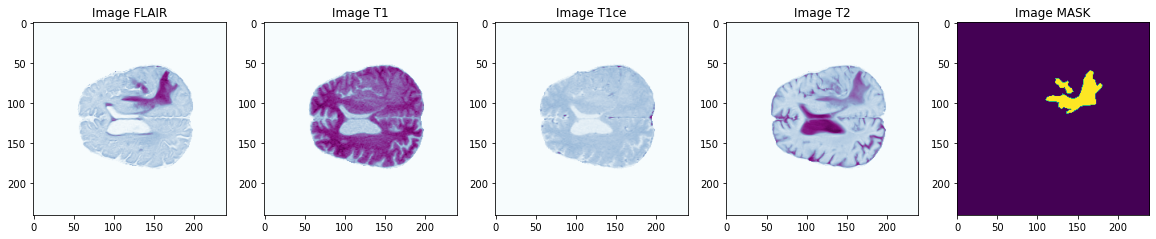

In [4]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_img_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_100/BraTS20_Training_100_flair.nii').get_fdata()
test_img_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_100/BraTS20_Training_100_t1.nii').get_fdata()
test_img_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_100/BraTS20_Training_100_t1ce.nii').get_fdata()
test_img_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_100/BraTS20_Training_100_t2.nii').get_fdata()
test_img_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_100/BraTS20_Training_100_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_img_flair[:,:,test_img_flair.shape[0]//2-slice_w], cmap = 'BuPu')
ax1.set_title('Image FLAIR')
ax2.imshow(test_img_t1[:,:,test_img_t1.shape[0]//2-slice_w], cmap = 'BuPu')
ax2.set_title('Image T1')
ax3.imshow(test_img_t1ce[:,:,test_img_t1ce.shape[0]//2-slice_w], cmap = 'BuPu')
ax3.set_title('Image T1ce')
ax4.imshow(test_img_t2[:,:,test_img_t2.shape[0]//2-slice_w], cmap = 'BuPu')
ax4.set_title('Image T2')
ax5.imshow(test_img_mask[:,:,test_img_mask.shape[0]//2-slice_w])
ax5.set_title('Image MASK')


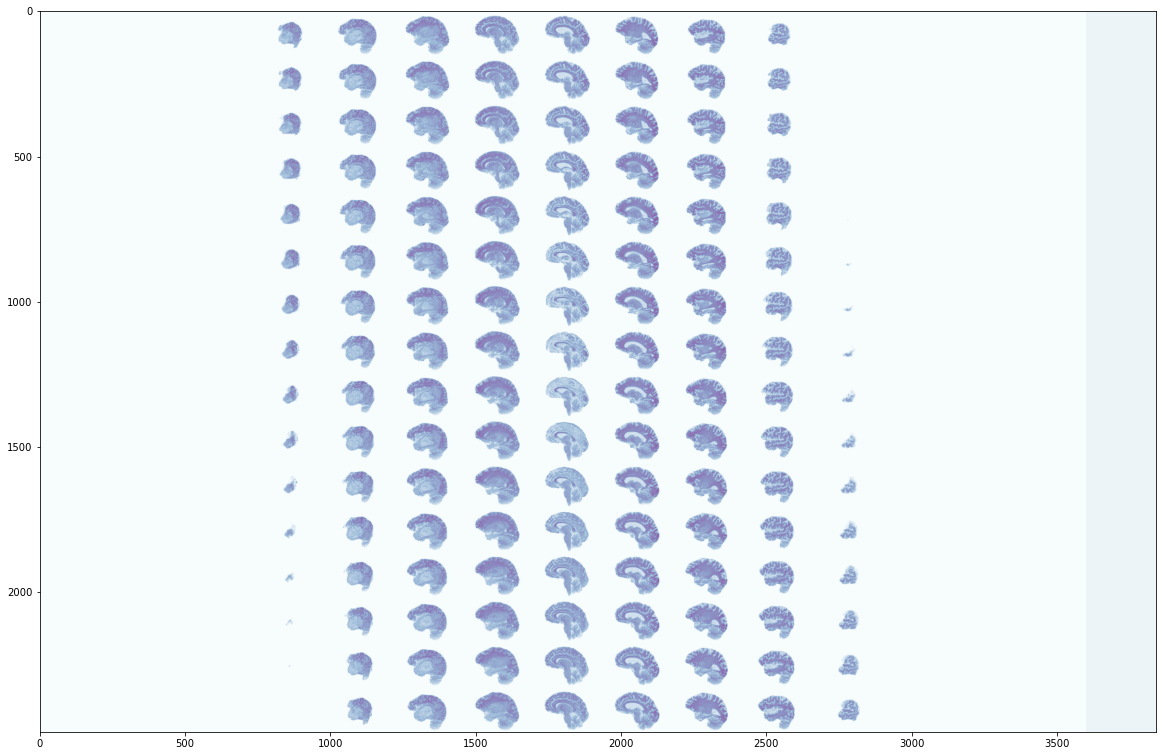

In [5]:
# Show whole nifti data -> print each slice from 3d data
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(test_img_t1[:,:,:]), 90, resize=True), cmap ='BuPu')

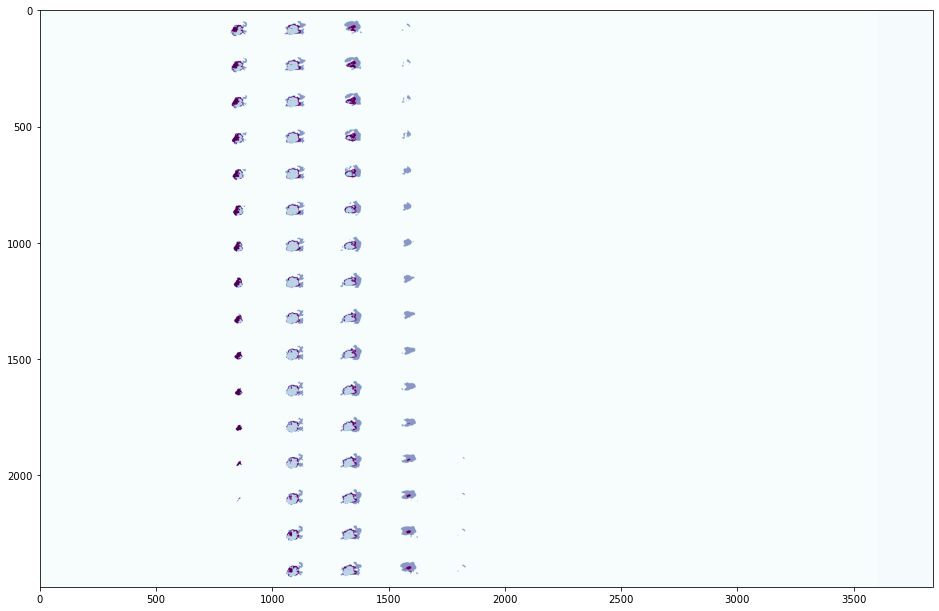

In [6]:
# Show the segmentation of tumor for each slices from above figure
fig, ax1 = plt.subplots(1, 1, figsize = (16,16))
ax1.imshow(rotate(montage(test_img_mask[:,:,:]), 90, resize=True), cmap ='BuPu')

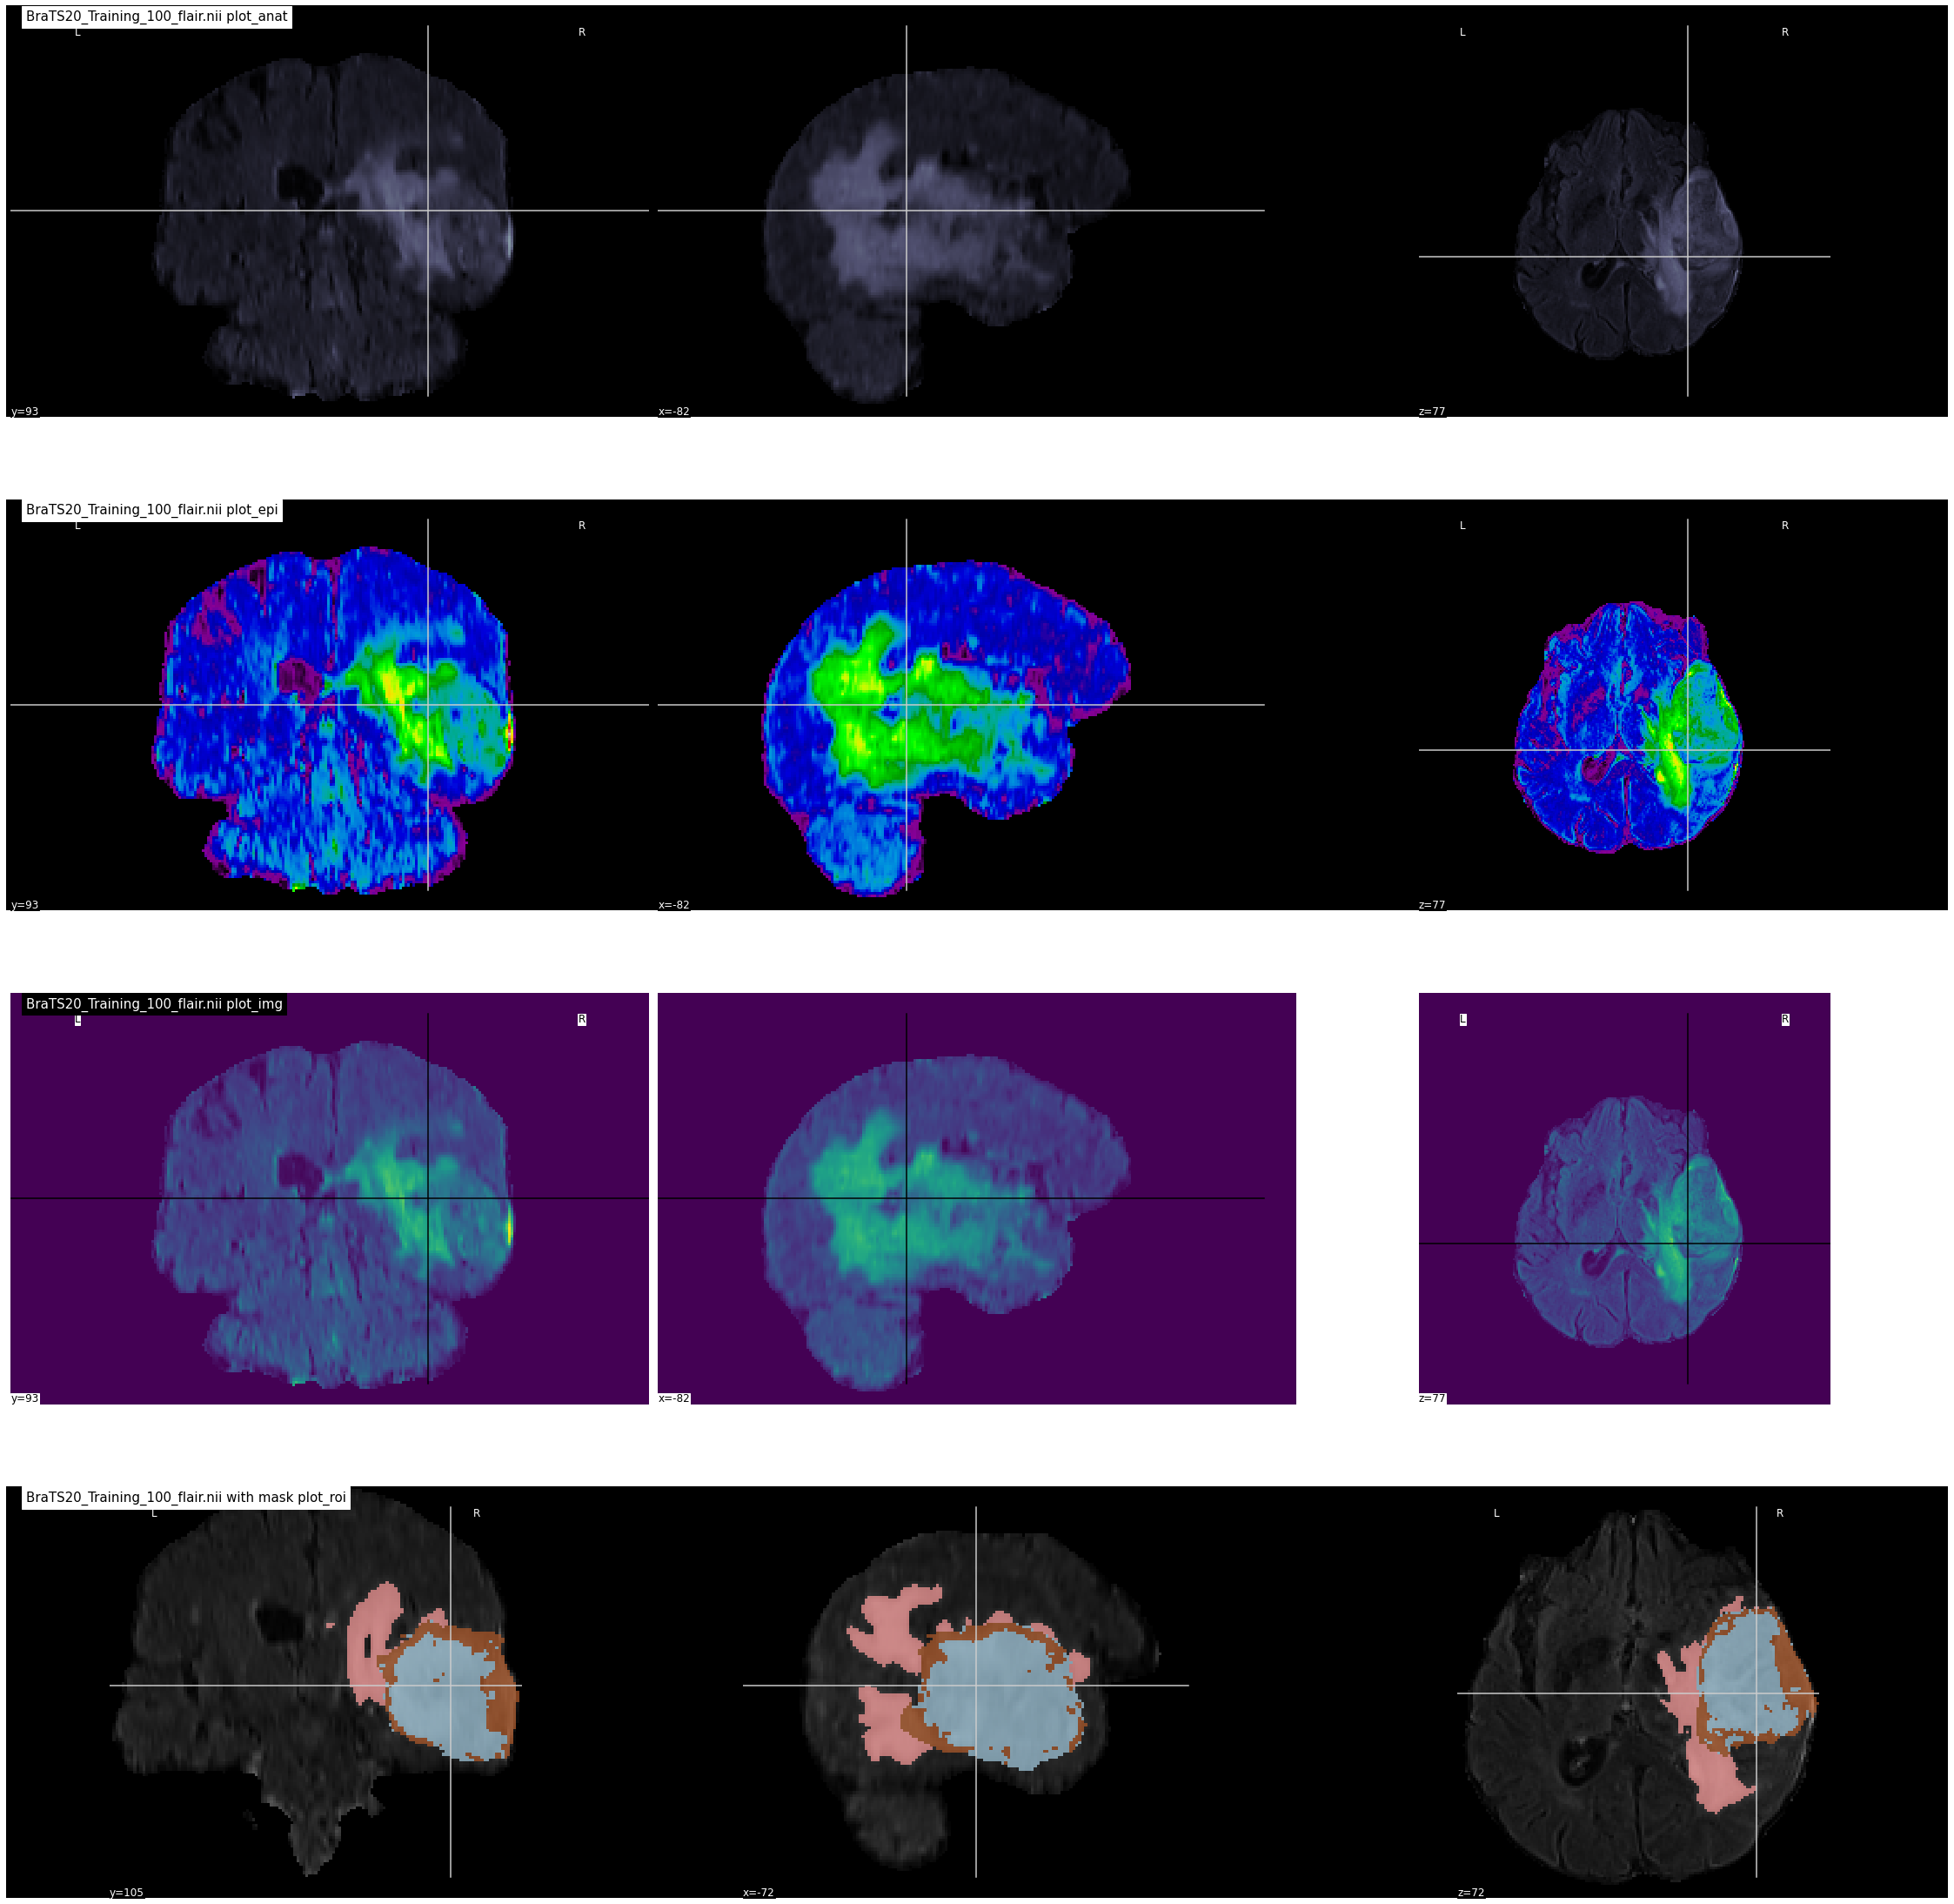

In [7]:
nii_img = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_100/BraTS20_Training_100_flair.nii')
nii_mask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_100/BraTS20_Training_100_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(40, 40))


nlplt.plot_anat(nii_img,
                title='BraTS20_Training_100_flair.nii plot_anat',
                axes=axes[0], cmap='bone')

nlplt.plot_epi(nii_img,
               title='BraTS20_Training_100_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(nii_img,
               title='BraTS20_Training_100_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nii_mask, 
               title='BraTS20_Training_100_flair.nii with mask plot_roi',
               bg_img=nii_img, 
               axes=axes[3], cmap='Paired')

plt.show()

# Creating the u-net model which actually is a type of convolutional networks for biomedical image segmentation



# The Dice coefficient 
is a common metric for pixel segmentation that can also be modified to act as a loss function, which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. 
Inspired by:
1. https://github.com/keras-team/keras/issues/9395
2. https://www.jeremyjordan.me/semantic-segmentation/

In [8]:
# Dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


 
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [9]:
IMG_SIZE=128 # 128x128px

In [10]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

**U-Net Model Architecture** 

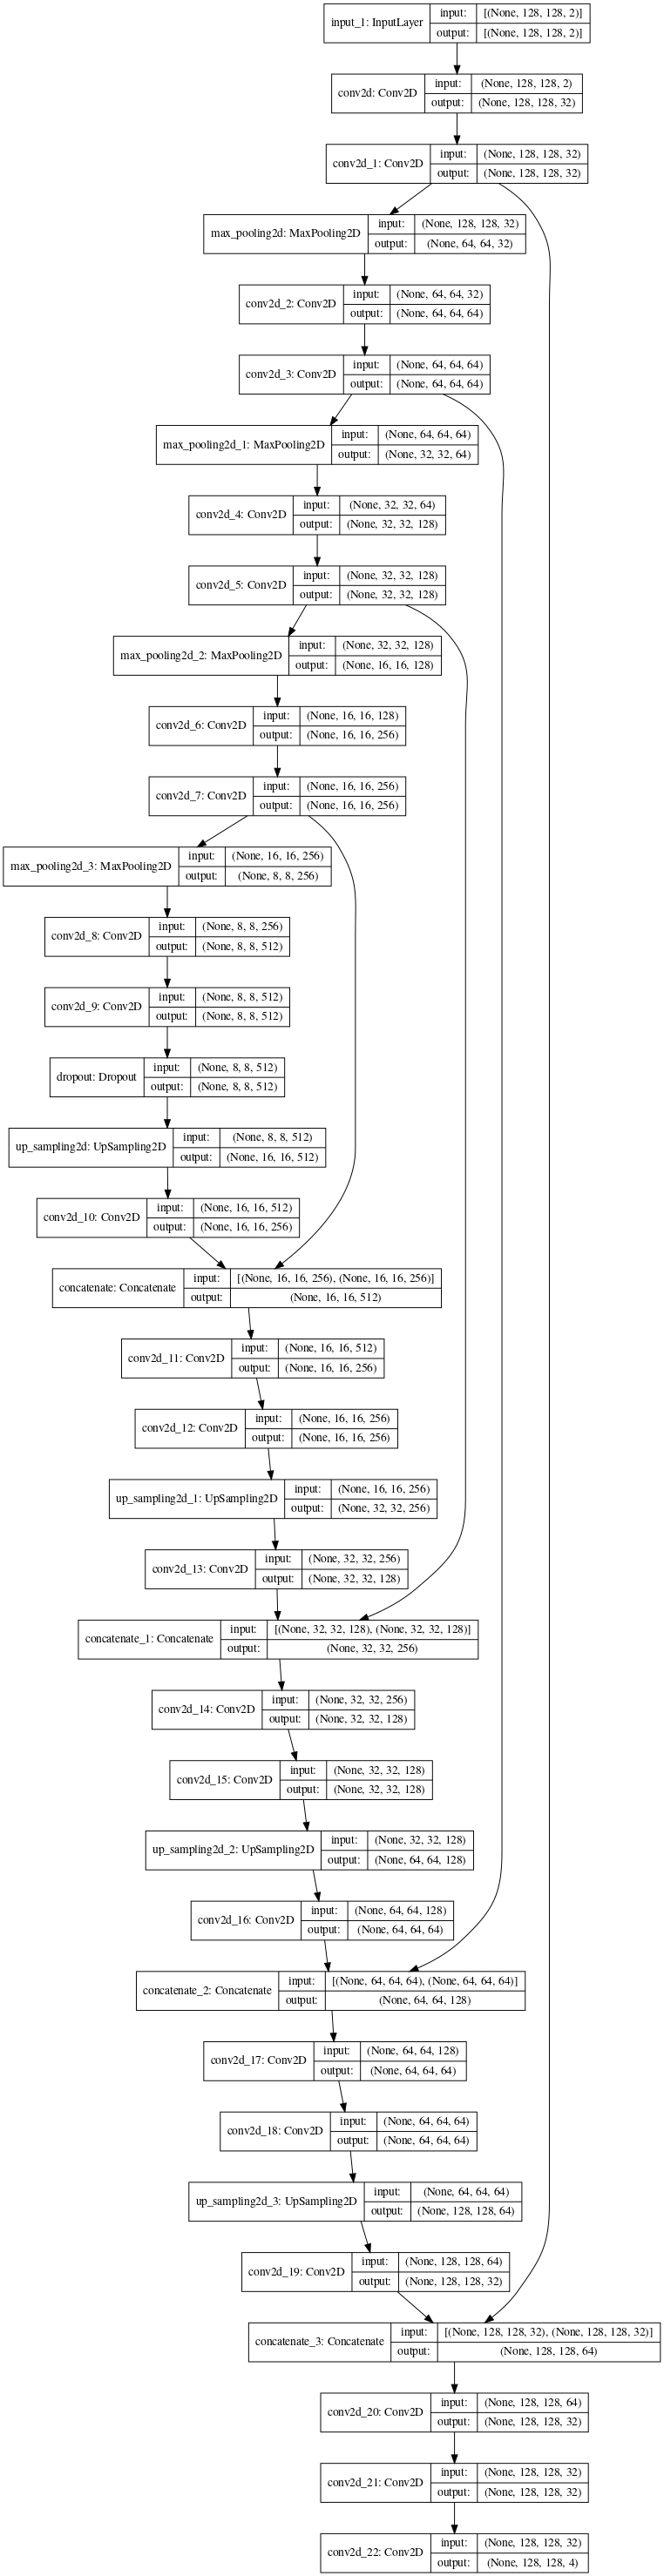

In [11]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# Load data
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [12]:
# Lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# File BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [13]:
# Override Keras sequence DataGenerator class
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Update indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch size samples' # X : (n_samples, *dim, n_channels)
        # Init
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

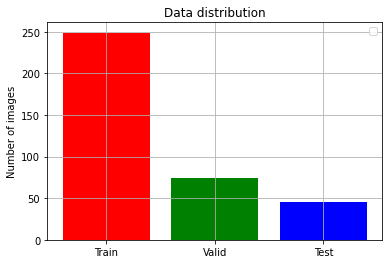

In [14]:
# Show number of data for each directory(training, validation, testing)
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'red','green', 'blue'])
    plt.legend()
    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.grid()
    plt.show()
    
showDataLayout()

In [15]:
# Add callback for training phase
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1), csv_logger]

# Train model

In [16]:
# Train and save the model 
K.clear_session()

# train_unet =  model.fit(training_generator,
#                     epochs=35,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )  
# model.save("model_x1_1.h5")

**Visualize the training process**

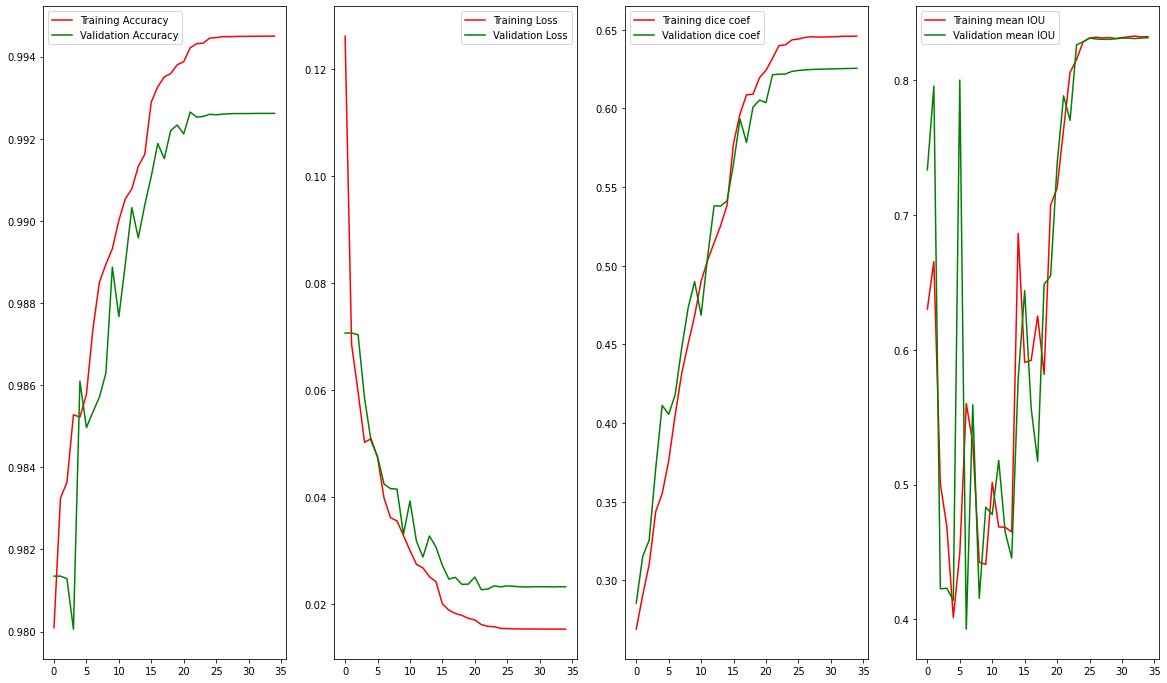

In [17]:
# Load previously trained model 
model = keras.models.load_model('../input/modelperclasseval/model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('../input/modelperclasseval/training_per_class.log', sep=',', engine='python')

hist=history # hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(20,12))

ax[0].plot(epoch,acc,'r',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'g',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'r',label='Training Loss')
ax[1].plot(epoch,val_loss,'g',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'r',label='Training dice coef')
ax[2].plot(epoch,val_dice,'g',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'r',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'g',label='Validation mean IOU')
ax[3].legend()

plt.show()

# Prediction examples 

In [18]:
# MRI scan type must one of 1.flair; 2.t1; 3.t1ce(t1 contrast-enhaced); 4.t2; or the already segmented version
# Returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# Load nifti file at "path" and load each slice with mask from volume
# Choose the MRI type & resize to `IMG_SIZE` 128pixels by default
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

4/4 [==============================] - 4s 99ms/step


<Figure size 1296x3600 with 0 Axes>

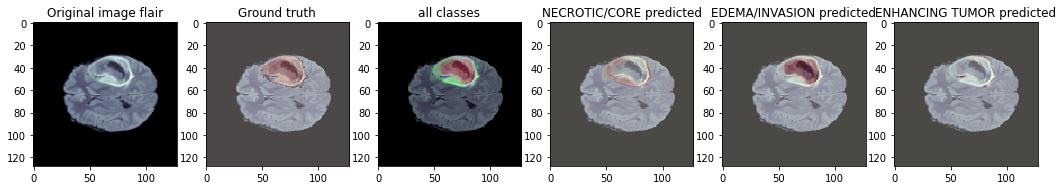

4/4 [==============================] - 0s 34ms/step


<Figure size 1296x3600 with 0 Axes>

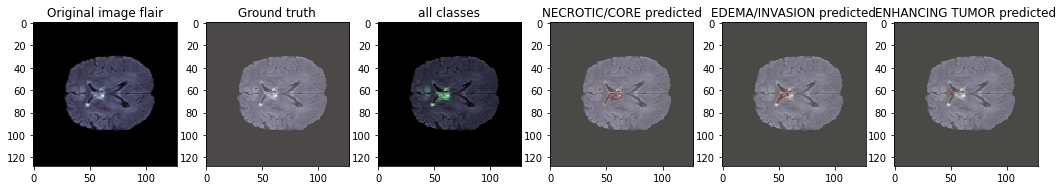

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

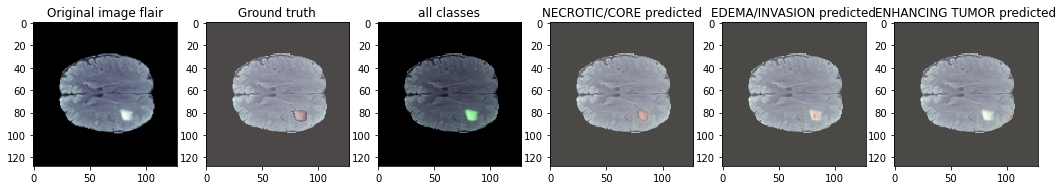

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

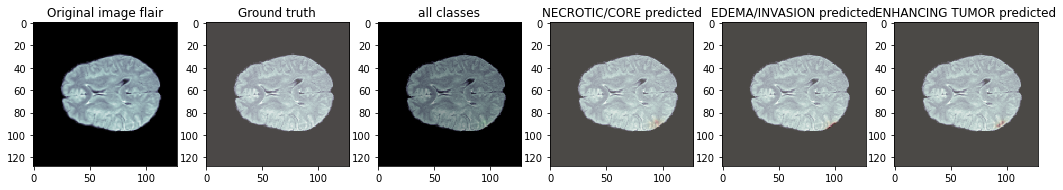

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

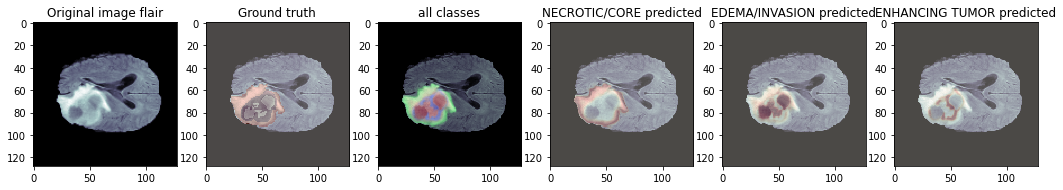

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

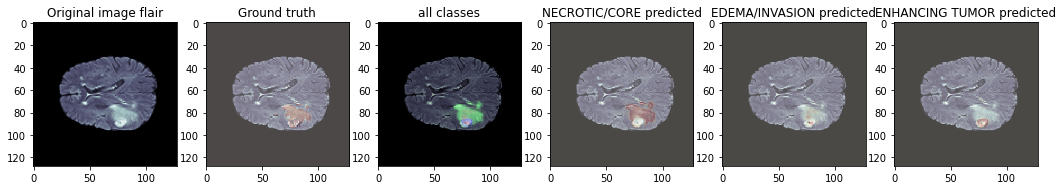

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

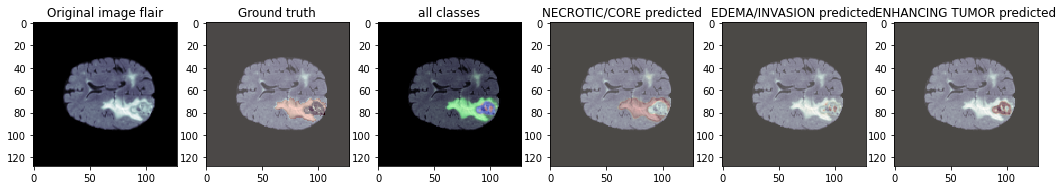

In [19]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
    seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
      

    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # For each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="bone", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="bone")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

# Evaluation

4/4 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

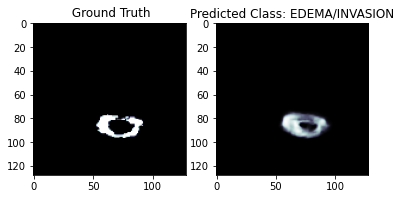

In [20]:
case = case=test_ids[3][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema = p[:,:,:,2]
enhancing = p[:,:,:,3]

i=25 # slice at
eval_class = 2 # 0:'NOT tumor',  1:'CORE',  2:'EDEMA/INVASION', 3:'ENHANCING TUMOR'
gt[gt != eval_class] = 1 # use only one class for per class evaluation 
resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="bone")
axarr[0].title.set_text(' Ground Truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="bone")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [21]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=128, callbacks= callbacks)


Evaluate on test data
45/45 [==============================] - 34s 705ms/step - loss: 0.0160 - accuracy: 0.9943 - mean_io_u_1: 0.8362 - dice_coef: 0.6443 - precision: 0.9946 - sensitivity: 0.9930 - specificity: 0.9982 - dice_coef_necrotic: 0.6666 - dice_coef_edema: 0.7694 - dice_coef_enhancing: 0.6563


# Survival prediction implementation


# Constants

In [22]:
# Define segmentation areas  
SEGMENT_CLASSES = {
    0 : 'NOT TUMOR',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA/INVASION',
    3 : 'ENHANCING' }

# Survival days estimated categories, 365 means 1 year
SURVIVAL_CATEGORIES= {
    'SHORT' : 0 , # 0-365
    'MEDIUM' : 365,  # 365-730
    'LONG' : 730, # <730 
}

# *Disclaimer*: there are 155 slices per volume
# To start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # First slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH='../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# Split dataset into train, validation and test sets

In [23]:
# Lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

**Check if the background of images contains only zero values**<br>
Visualize zero values in image (black pixels/values -> background) , converted into another color so its easier to see 

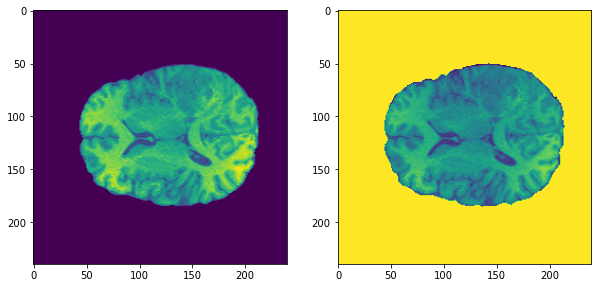

In [24]:
my_loc_slice=75
image_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_050/BraTS20_Training_050_t1.nii').get_fdata()
my_img=image_volume[:,:,my_loc_slice]
my_converted_img = my_img.copy()
my_converted_img[my_converted_img == 0] = 666


f, axarr = plt.subplots(1,2, figsize = (10, 5))
axarr[0].imshow(my_img)
axarr[1].imshow(my_converted_img)

Count number of pixels for each segment for each slice in volume

In [25]:
def maskSizeForSlice(path,i_slice):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    image_volume=nib.load(path).get_fdata()
    # Flatten 3D image into 1D array and convert mask 4 to 2
    arr=image_volume[:,:,i_slice].flatten()
    arr[arr == 4] = 3

    unique, counts = np.unique(arr, return_counts=True)
    unique = unique.astype(int)
    values_dict=dict(zip(unique, counts))
    for k in range(1,4):
        totals[k] += values_dict.get(k,0)
    return totals

count class 1: 844
{1: 844, 2: 77, 3: 917}


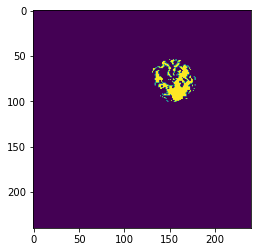

In [26]:
my_loc_slice=75
my_loc_class=1
seg_sum=maskSizeForSlice(TRAIN_DATASET_PATH+'BraTS20_Training_050/BraTS20_Training_050_seg.nii',my_loc_slice)


image_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_050/BraTS20_Training_050_seg.nii').get_fdata()
image_loc=image_volume[:,:,my_loc_slice]
image_loc[image_loc != my_loc_class] = 0

# Plot figure segment only for class 'my_loc_class'
plt.imshow(image_loc)

image_loc=image_loc.flatten()
count = np.count_nonzero(image_loc == my_loc_class)
print(f'count class {my_loc_class}: {count}')
print(seg_sum)

# Survival prediction
**Lets see what is the age distrubution in our dataset and their survival days**<br>
skip not GTR values

In [27]:
csv_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv'

age_dict = {}
days_dict = {}


with open(csv_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
  #  row_count = sum(1 for row in csv_reader)
 #   print(f'total rows: {row_count} .')
    at_line = 0
    category_short = 0
    category_medium = 0
    category_long = 0
    max_days = 0
    for row in csv_reader:
        if at_line == 0:
            print(f'Column names are {", ".join(row)}')
            at_line += 1
        else:
            if (row[3] != "GTR"):
                continue
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            if (not days.isnumeric()):
                continue
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            max_days = max(max_days,int(days))
            if int(days) < 365:
                category_short += 1
            elif (int(days) >= 365 and int(days) <= 730):
                category_medium += 1
            else:
                category_long += 1
            at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Column names are Brats20ID, Age, Survival_days, Extent_of_Resection
['BraTS20_Training_001', '60.463', '289', 'GTR']
['BraTS20_Training_002', '52.263', '616', 'GTR']
['BraTS20_Training_003', '54.301', '464', 'GTR']
['BraTS20_Training_004', '39.068', '788', 'GTR']
['BraTS20_Training_005', '68.493', '465', 'GTR']
['BraTS20_Training_006', '67.126', '269', 'GTR']
['BraTS20_Training_007', '69.912', '503', 'GTR']
['BraTS20_Training_009', '56.419', '1155', 'GTR']
['BraTS20_Training_010', '48.367', '515', 'GTR']
['BraTS20_Training_012', '65.899', '495', 'GTR']
['BraTS20_Training_013', '59.693', '698', 'GTR']
['BraTS20_Training_014', '51.734', '359', 'GTR']
['BraTS20_Training_015', '62.614', '169', 'GTR']
['BraTS20_Training_016', '55.759', '368', 'GTR']
['BraTS20_Training_017', '58.258', '439', 'GTR']
['BraTS20_Training_018', '61.605', '486', 'GTR']
['BraTS20_Training_019', '68.049', '287', 'GTR']
['BraTS20_Training_021', '56.921', '576', 'GTR']
['BraTS20_Training_022', '44.162', '350', 'GTR']


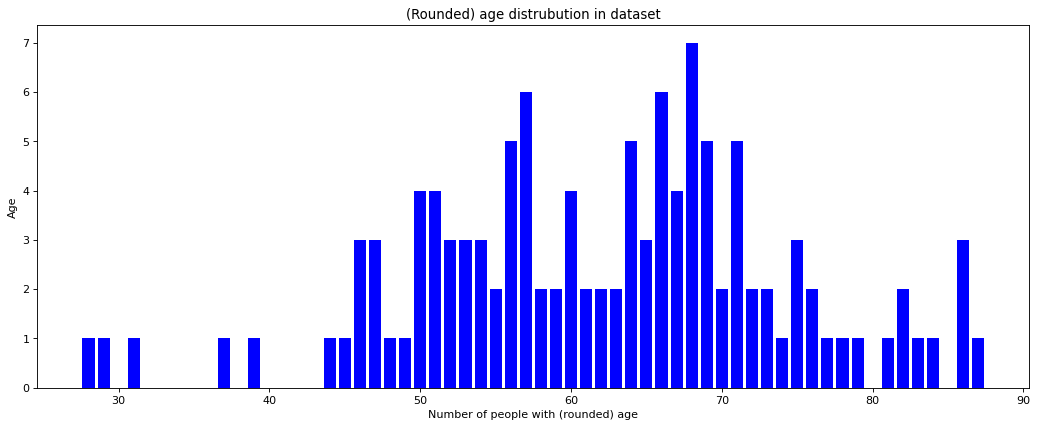

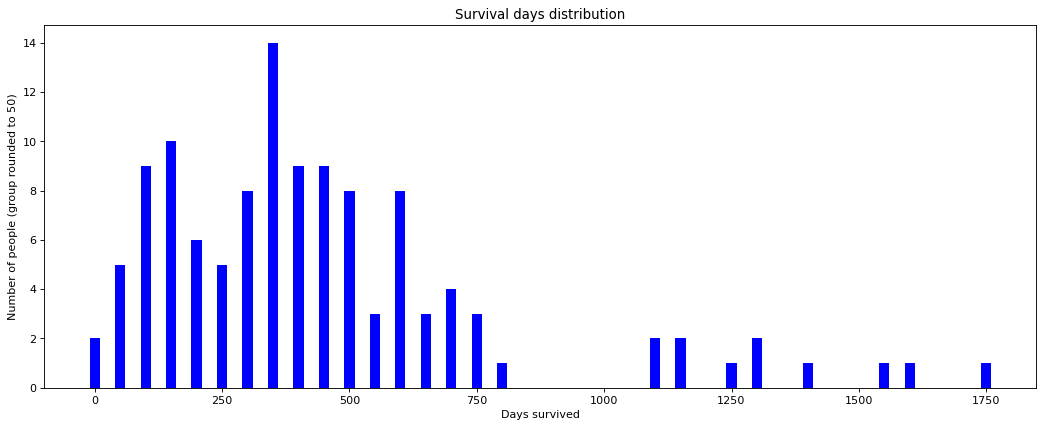

In [28]:
# Age dictionary, round values > no floating point
age_dict_rounded = {key : round(age_dict[key], 0) for key in age_dict}

# Survival days dictionary
days_dict_rounded = {key : round(days_dict[key]/50)*50 for key in days_dict}
days_dict_rounded_counted = Counter(days_dict_rounded.values())

# Count same numbers, creating statistics how many times is there person with same age
age_dict_rounded_counted = Counter(age_dict_rounded.values())
days_dict_rounded_counted = Counter(days_dict_rounded.values())

cycol = cycle('bgrcmk')
colors = list()
for i in range(len(age_dict_rounded_counted)):
    colors.append(next(cycol))
    
cycol = cycle('bgrcmk')    
colorsDays = list()
for i in range(len(days_dict_rounded_counted)):
    colorsDays.append(next(cycol))

plt.figure(figsize=(16, 6), dpi=80)
plt.xlabel('Number of people with (rounded) age')
plt.ylabel('Age')
plt.title("(Rounded) age distrubution in dataset")
plt.bar(list(age_dict_rounded_counted.keys()), age_dict_rounded_counted.values(), color='blue')
plt.show()

plt.figure(figsize=(16, 6), dpi=80)
plt.xlabel('Days survived')
plt.ylabel('Number of people (group rounded to 50)')
plt.title("Survival days distribution")
plt.bar(list(days_dict_rounded_counted.keys()), days_dict_rounded_counted.values(),width=20, color='blue')
plt.show()

# Computing segment sizes
Find number of pixels for each class in volume, no need to compute as ration to image size, since all images are of same size 240x240

In [29]:
# Get number of pixels for each segment as dictionary
# Original images contain segment values
def getMaskSizesForVolume(image_volume):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    for i in range(VOLUME_SLICES):
        # Flatten 2D image into 1D array and convert mask 4 to 2
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        arr[arr == 4] = 3 # (0,1,2,4) so 4 is our 3, (0,1,2,3)
        
        unique, counts = np.unique(arr, return_counts=True)
        unique = unique.astype(int)
        values_dict=dict(zip(unique, counts))
        for k in range(1,4):
            totals[k] += values_dict.get(k,0)
    return totals

**Compute brain volume size** ignoring background

total count: 1428957


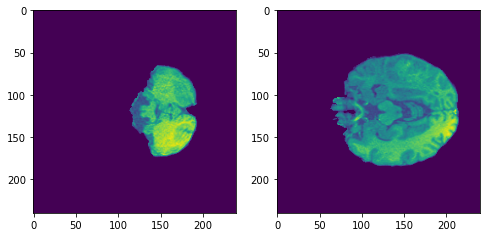

In [30]:
# Returns count of non-zero elements in whole 3D volume
def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_050/BraTS20_Training_050_t1.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

In [31]:
# ID: Age, Categories
def getListAgeDays(id_list):
    x_val = []
    y_val = []
    for i in id_list:
        if (i not in age_dict):
            continue
        masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii').get_fdata())
        brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii').get_fdata())
        masks[1] = masks[1]/brain_vol
        masks[2] = masks[2]/brain_vol
        masks[3] = masks[3]/brain_vol
        merged=[age_dict[i],masks[1],masks[2],masks[3]] # Add Segments
        x_val.append(merged) 
        if (days_dict[i] < 365):
            y_val.append([1,0,0])
        elif (days_dict[i] >= 365 and days_dict[i] < 730):
            y_val.append([0,1,0])
        else:
            y_val.append([0,0,1])
            
    return np.array(x_val), np.array(y_val)

X_all, y_all = getListAgeDays(train_and_test_ids)

print(f'X_test: {X_all.shape}')
df = pd.DataFrame(np.concatenate((X_all, y_all), axis=1) , columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}","short","medium","long"])
df.head()

X_test: (118, 4)


,age,NECROTIC/CORE,EDEMA/INVASION,ENHANCING,short,medium,long
0,54.915,0.002438,0.045368,0.005153,0.0,1.0,0.0
1,57.000,0.015202,0.039171,0.019636,0.0,0.0,1.0
2,60.000,0.004592,0.027417,0.030548,0.0,1.0,0.0
3,83.649,0.039530,0.048636,0.025146,1.0,0.0,0.0
4,60.019,0.000448,0.018200,0.007183,0.0,1.0,0.0


Normalize the data performing min-max scaling into range 0 - 1

In [32]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled

df = pd.DataFrame(X_all, columns = ["age normalised",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])
display(df)

,age normalised,NECROTIC/CORE,EDEMA/INVASION,ENHANCING
0,0.460631,0.060053,0.330630,0.105513
1,0.496066,0.374441,0.283556,0.406350
2,0.547051,0.113117,0.194263,0.633018
3,0.948964,0.973691,0.355460,0.520813
4,0.547373,0.011033,0.124241,0.147677
...,...,...,...,...
113,1.000000,0.337023,0.507990,0.673251
114,0.795687,0.207157,0.222702,0.605692
115,0.779440,0.037349,0.208887,0.115095
116,0.807277,0.383568,0.179196,0.338549


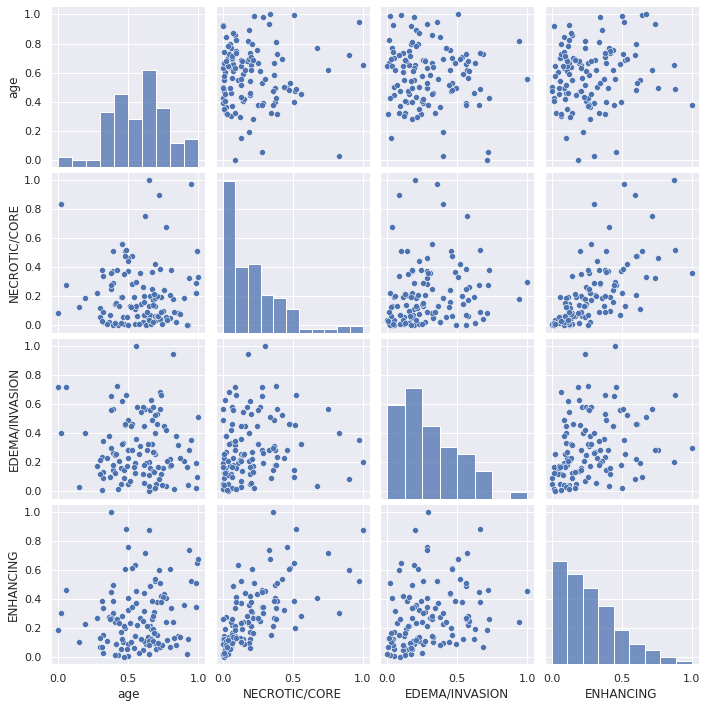

In [33]:
# View data distributions
sns.set()

df = pd.DataFrame(X_all, columns = ["age", SEGMENT_CLASSES[1],SEGMENT_CLASSES[2],SEGMENT_CLASSES[3]])
sns.pairplot(df, diag_kind='auto') 

Train test split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 10, shuffle = True)


print("x_train shape:",X_train.shape)
print("x_test shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (94, 4)
x_test shape: (94, 4)
y_train shape: (94, 3)
y_test shape: (24, 3)


Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=100, random_state=1, max_features=4, n_jobs=-1,
                            criterion='entropy',max_depth=10)

# Fit the model to the training set
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))



accuracies = cross_val_score(rfc, X_train, y_train, cv=10)
rfc.fit(X_train,y_train)

print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",rfc.score(X_test,y_test))

Model accuracy score: 0.3333
Cross validation: Train Score: 0.4988888888888889
Cross validation: Test Score: 0.3333333333333333


**Visualize the most important features**<br>
We can see that the most important feature is age

In [60]:
df = pd.DataFrame(X_train, columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])

feature_scores = pd.Series(rfc.feature_importances_, index=df.columns).sort_values(ascending=False)
feature_scores

age               0.283513
NECROTIC/CORE     0.266441
ENHANCING         0.264456
EDEMA/INVASION    0.185589
dtype: float64

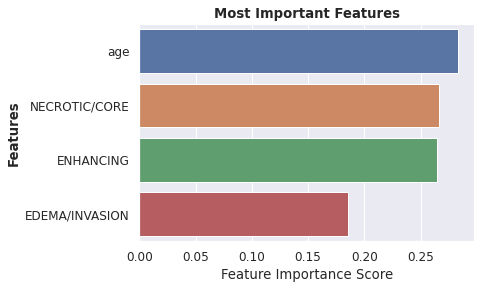

In [62]:
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features',fontweight='bold')
plt.title("Most Important Features", fontweight='bold')
plt.show()

# Confusion Matrix

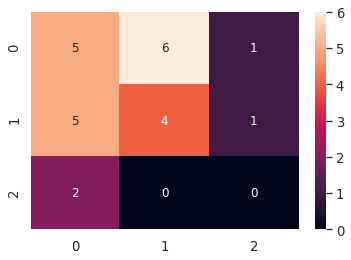

In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [39]:
# Classification report

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.40      0.40      0.40        10
           2       0.00      0.00      0.00         2

   micro avg       0.38      0.38      0.38        24
   macro avg       0.27      0.27      0.27        24
weighted avg       0.38      0.38      0.38        24
 samples avg       0.38      0.38      0.38        24



**Gridsearch**<br>
To find best score, I will try different value of:
1. n_estimators -> in range (1,100) with step 1
2. criterion parameters -> gini and entropy

In [67]:
grid = {
    'n_estimators':np.arange(1,100,1),
    'criterion':['entropy', 'gini'] }

rfc_ = RandomForestClassifier(random_state = 1)
rf_grid = GridSearchCV(rfc_, grid, cv=5)
rf_grid.fit(X_train,y_train)

print("Random Forest Best Parameters:",rf_grid.best_params_)
print("Train Score:", rf_grid.best_score_)
print("Test Score:",rf_grid.score(X_test,y_test))

Random Forest Best Parameters: {'criterion': 'entropy', 'n_estimators': 9}
Train Score: 0.5432748538011696
Test Score: 0.4583333333333333


SVM Classifier

In [65]:
from sklearn.svm import SVC

y_train_multi=np.argmax(y_train, axis=1)
y_test_multi =np.argmax(y_test, axis=1)

svc = SVC(C=1.0, kernel='sigmoid', coef0=1.0, gamma=1, degree=3, random_state = 10, verbose = True)
svc.fit(X_train,y_train_multi)
accuracies = cross_val_score(svc, X_train, y_train_multi)


y_pred = svc.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc.score(X_test,y_test_multi))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Model accuracy score : 0.5000
Train Score: 0.47894736842105257
Test Score: 0.5


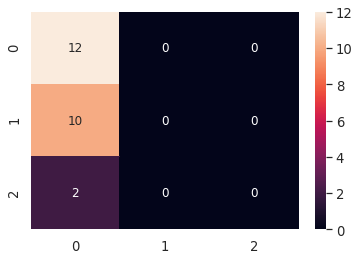

In [42]:
# Convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm_svc = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))
sns.set(font_scale=1.2) 
sns.heatmap(cm_svc, annot=True, annot_kws={"size": 12}) 

plt.show()

In [43]:
print(classification_report(y_test_multi, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        12
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         2

    accuracy                           0.50        24
   macro avg       0.17      0.33      0.22        24
weighted avg       0.25      0.50      0.33        24



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
grid = {
    'C':[0.01,0.1,1,10,15,20],
    'kernel' : ["linear","poly","rbf","sigmoid"],
    'degree' : [1,3,5,7],
    'coef0'  : [1.0, 0.0],
    'gamma'  : [0.01,1]
}

svm  = SVC();
svm_grid = GridSearchCV(svm, grid, cv = 5)
svm_grid.fit(X_train,y_train_multi)
print("SVC Best Parameters:",svm_grid.best_params_)
print("Train Score:",svm_grid.best_score_)
print("Test Score:",svm_grid.score(X_test,y_test_multi))

SVC Best Parameters: {'C': 15, 'coef0': 1.0, 'degree': 7, 'gamma': 0.01, 'kernel': 'poly'}
Train Score: 0.5847953216374269
Test Score: 0.625


KNN Classifier

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn  = KNeighborsClassifier(n_neighbors=38, p=2, weights='distance')
knn.fit(X_train,y_train_multi)
accuracies = cross_val_score(knn, X_train, y_train_multi)

y_pred = knn.predict(X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))
print("Train Score:",np.mean(accuracies))
print("Test Score:",knn.score(X_test,y_test_multi))

Model accuracy score: 0.5000
Train Score: 0.5742690058479532
Test Score: 0.5


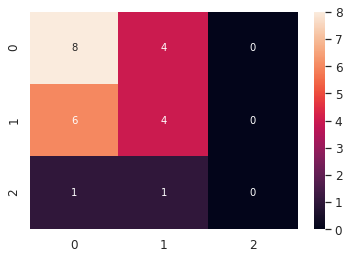

In [46]:
# Convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm_knn = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.1) 
sns.heatmap(cm_knn, annot=True, annot_kws={"size": 10}) 

plt.show()

In [47]:
print(classification_report(y_test_multi, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59        12
           1       0.44      0.40      0.42        10
           2       0.00      0.00      0.00         2

    accuracy                           0.50        24
   macro avg       0.33      0.36      0.34        24
weighted avg       0.45      0.50      0.47        24



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
grid = {
    'n_neighbors':np.arange(1,75),
    'p':np.arange(1,5),
    'weights':['uniform','distance']
    }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn,grid,cv=5)
knn_grid.fit(X_train,y_train_multi)

print("KNN Best Parameters:",knn_grid.best_params_)
print("Train Score:",knn_grid.best_score_)
print("Test Score:",knn_grid.score(X_test,y_test_multi))

KNN Best Parameters: {'n_neighbors': 59, 'p': 1, 'weights': 'distance'}
Train Score: 0.6590643274853802
Test Score: 0.5416666666666666


In [75]:
print("Random Forest Best Parameters:",rf_grid.best_params_)
print("Train Score:", rf_grid.best_score_)
print("Test Score:",rf_grid.score(X_test,y_test))

print("KNN Best Parameters:",knn_grid.best_params_)
print("Train Score:",knn_grid.best_score_)
print("Test Score:",knn_grid.score(X_test,y_test_multi))

print("SVC Best Parameters:",svm_grid.best_params_)
print("Train Score:",svm_grid.best_score_)
print("Test Score:",svm_grid.score(X_test,y_test_multi))

Random Forest Best Parameters: {'criterion': 'entropy', 'n_estimators': 9}
Train Score: 0.5432748538011696
Test Score: 0.4583333333333333
KNN Best Parameters: {'n_neighbors': 59, 'p': 1, 'weights': 'distance'}
Train Score: 0.6590643274853802
Test Score: 0.5416666666666666
SVC Best Parameters: {'C': 15, 'coef0': 1.0, 'degree': 7, 'gamma': 0.01, 'kernel': 'poly'}
Train Score: 0.5847953216374269
Test Score: 0.625
